## API

In [ ]:
# Список городов
regions = {
    "Москва": 1,
    "Санкт-Петербург": 2,
    "Новосибирск": 4,
    "Екатеринбург": 3,
    "Казань": 88
}

# Количество вакансий
per_page = 100
total_vacancies = 400  # Можно увеличить после теста

vacancies = []

# Функция для безопасного запроса (с повторными попытками)
def safe_request(url, params=None, max_retries=5, timeout=10):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=timeout)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Ошибка {response.status_code}: {response.text}")
        except requests.exceptions.Timeout:
            print(f"Попытка {attempt + 1}: Превышено время ожидания запроса ({url})")
        except requests.exceptions.RequestException as e:
            print(f"Попытка {attempt + 1}: Ошибка запроса - {e}")

        time.sleep(2)  # Ждём перед новой попыткой
    return None  # Если не получилось, возвращаем None

# Цикл сбора данных
for city, area_id in regions.items():
    print(f"Собираем вакансии для {city}...")

    for page in range(total_vacancies // per_page):
        params = {
            "text": "аналитик",
            "search_field": "name",  # Только в названии вакансии
            "area": area_id,
            "per_page": per_page,
            "page": page,
            "only_with_salary": True
        }

        # Запрос списка вакансий
        data = safe_request("https://api.hh.ru/vacancies", params=params)

        if data:
            for vacancy in data.get("items", []):
                vacancy_id = vacancy["id"]
                details_url = f"https://api.hh.ru/vacancies/{vacancy_id}"

                # Запрос деталей вакансии
                details = safe_request(details_url)

                key_skills = [skill["name"] for skill in details.get("key_skills", [])] if details else []

                salary = vacancy.get("salary", {})

                vacancies.append({
                    "Название": vacancy.get("name"),
                    "Компания": vacancy.get("employer", {}).get("name"),
                    "Регион": vacancy.get("area", {}).get("name"),
                    "Опыт работы": vacancy.get("experience", {}).get("name"),
                    "Зарплата от": salary.get("from"),
                    "Зарплата до": salary.get("to"),
                    "Валюта": salary.get("currency"),
                    "Требования": vacancy.get("snippet", {}).get("requirement"),
                    "Ключевые навыки": ", ".join(key_skills) if key_skills else "Не указаны",
                    "Ссылка": vacancy.get("alternate_url")
                })

                time.sleep(0.2)  # Небольшая задержка

        time.sleep(3)  # Даем API немного "отдохнуть"

# Сохраняем результат
df = pd.DataFrame(vacancies)
df.to_csv("vacancies_full_2.csv", index=False, encoding="utf-8-sig")

print("Данные обновлены и сохранены в vacancies_full_2.csv")


## Подключение библиотек и датасета

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
df = pd.read_csv('vacancies.csv')
df.head()

,Название,Компания,Регион,Опыт работы,Зарплата от,Зарплата до,Валюта,Требования,Ключевые навыки,Ссылка
0,Политический аналитик / обозреватель,Вавилон,Москва,От 1 года до 3 лет,150000.0,NaN,RUR,Английский язык (уровень от В2 и выше). Навык ...,"Политическая журналистика, Мониторинг СМИ, Нап...",https://hh.ru/vacancy/117722682
1,BI-аналитик,Топассистент,Москва,От 3 до 6 лет,400000.0,NaN,RUR,опыт работы в роли <highlighttext>аналитика</h...,"Power BI, Python, SQL, BI-системы, Базы данных...",https://hh.ru/vacancy/117723095
2,Оператор-аналитик в Excel,Керамик Молл,Москва,Более 6 лет,40000.0,60000.0,RUR,"Внимательность, аналитический склад ума. Знани...",Не указаны,https://hh.ru/vacancy/117785917
3,Аналитик данных в Excel,Genesis,Москва,От 1 года до 3 лет,50000.0,NaN,RUR,Уверенный пользователь ПК (Excel). Опыт выгруз...,Не указаны,https://hh.ru/vacancy/117640799
4,Аналитик,Глонасс,Москва,Нет опыта,200000.0,200000.0,RUR,Высшее экономическое образование. Цифровая гра...,"Автоматизация, Автоматизация процессов, Автома...",https://hh.ru/vacancy/116814056


## Загрузка данных, проверка на дубликаты и пропущенные значнения

In [4]:
# Удаляем дубликаты
df1 = df.copy()
df = df.drop_duplicates()

# Проверяем пропущенные значения
missing_values = df.isna().sum()
print("Пропущенные значения:\n", missing_values)

# Удаляем строки, где нет зарплаты (если будем анализировать ЗП)
df = df.dropna(subset=["Зарплата от", "Зарплата до"])

# Приводим столбцы к удобному формату (например, убираем лишние пробелы)
df.columns = df.columns.str.strip()

# Сохраняем чистый датасет
df.to_csv("vacancies_clean.csv", index=False, encoding="utf-8-sig")
print("Данные очищены и сохранены в vacancies_clean.csv")


Пропущенные значения:
 Название             0
Компания             0
Регион               0
Опыт работы          0
Зарплата от        169
Зарплата до        526
Валюта               0
Требования           6
Ключевые навыки      0
Ссылка               0
dtype: int64
Данные очищены и сохранены в vacancies_clean.csv


In [3]:
df = pd.read_csv("vacancies_clean.csv")
print(df.isna().sum())
print(df.shape)
df

Название           0
Компания           0
Регион             0
Опыт работы        0
Зарплата от        0
Зарплата до        0
Валюта             0
Требования         5
Ключевые навыки    0
Ссылка             0
dtype: int64
(473, 10)


,Название,Компания,Регион,Опыт работы,Зарплата от,Зарплата до,Валюта,Требования,Ключевые навыки,Ссылка
0,Оператор-аналитик в Excel,Керамик Молл,Москва,Более 6 лет,40000.0,60000.0,RUR,"Внимательность, аналитический склад ума. Знани...",Не указаны,https://hh.ru/vacancy/117785917
1,Аналитик,Глонасс,Москва,Нет опыта,200000.0,200000.0,RUR,Высшее экономическое образование. Цифровая гра...,"Автоматизация, Автоматизация процессов, Автома...",https://hh.ru/vacancy/116814056
2,Системный аналитик,Группа компаний МЕДСИ,Москва,От 1 года до 3 лет,200000.0,250000.0,RUR,Мы хотим работать с тобой. Опыт работы системн...,"SQL, XML, BPMN, UML, Аналитическое мышление, Б...",https://hh.ru/vacancy/117791121
3,Junior Data Scientist \ Аналитик,M1,Москва,От 1 года до 3 лет,50000.0,60000.0,RUR,Работать с большими объемами данных. Анализиро...,"Python, PostgreSQL, MariaDB, Clickhouse, MS SQL",https://hh.ru/vacancy/117152095
4,Стажер Бизнес-аналитик ВТБ Юниор,Банк ВТБ (ПАО),Москва,Нет опыта,75000.0,75000.0,RUR,"Учишься на экономической, математической, техн...",Не указаны,https://hh.ru/vacancy/117579801
...,...,...,...,...,...,...,...,...,...,...
468,Менеджер маркетплейсов-аналитик (подбор товаро...,Майоров Андрей Юрьевич,Казань,От 1 года до 3 лет,40000.0,60000.0,RUR,"Вы командный игрок, умеете ставить себе задачи...","Грамотная речь, Аналитическое мышление, Анализ...",https://hh.ru/vacancy/117018008
469,Аналитик (Маркетплейсы),SONOX,Казань,От 1 года до 3 лет,50000.0,150000.0,RUR,НАВЫКИ (HARD SKILLS). — Опыт работы <highlight...,Не указаны,https://hh.ru/vacancy/117112429
470,Системный аналитик 1С,"ИНКОМСИСТЕМ, НИЦ",Казань,От 1 года до 3 лет,150000.0,150000.0,RUR,"Опыт ведения каких-либо проектов в целом, или ...","1С: Предприятие 8, 1С: Документооборот, 1С: За...",https://hh.ru/vacancy/115785283
471,Бизнес-аналитик amoCRM в it-компанию,Натфуллин Рушан Рустемович,Казань,От 1 года до 3 лет,40000.0,60000.0,RUR,Опыт работы в аналогичной должности от 1 года....,Не указаны,https://hh.ru/vacancy/116857700


## Визуализация данных

### 1. Анализ востребованных навыков

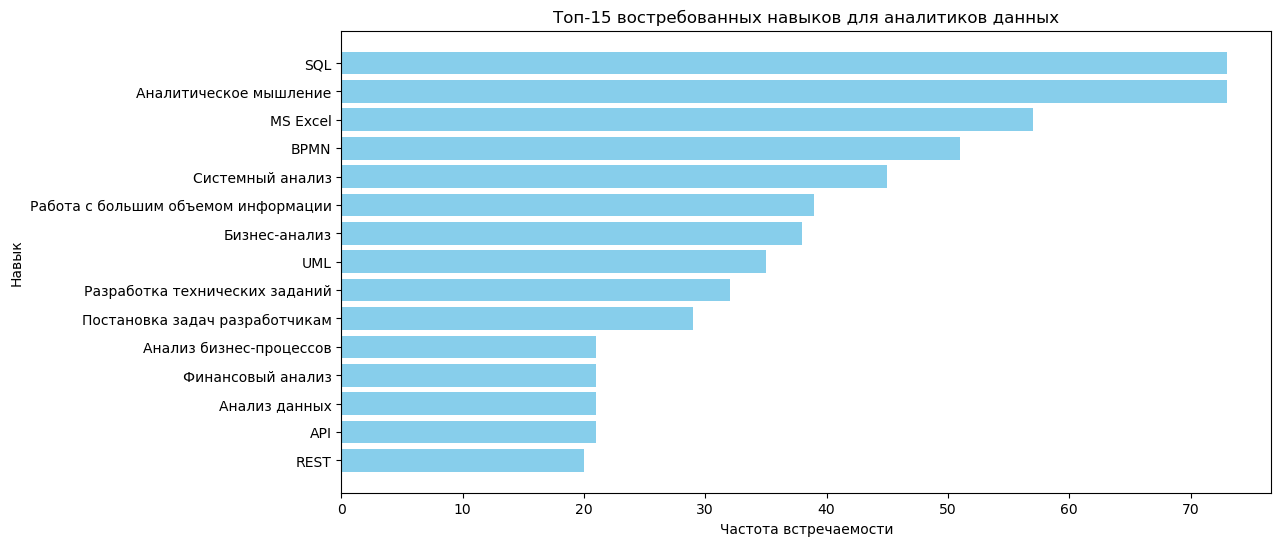

In [19]:
all_skills = df[df["Ключевые навыки"] != "Не указаны"]["Ключевые навыки"].dropna().str.split(", ")
all_skills = [skill for sublist in all_skills for skill in sublist]  # Разворачиваем список

# Считаем частоту встречаемости
skills_counter = Counter(all_skills)
top_skills = skills_counter.most_common(15)  # Топ-15 навыков

# График
plt.figure(figsize=(12, 6))
plt.barh([x[0] for x in top_skills], [x[1] for x in top_skills], color="skyblue")
plt.xlabel("Частота встречаемости")
plt.ylabel("Навык")
plt.title("Топ-15 востребованных навыков для аналитиков данных")
plt.gca().invert_yaxis()
plt.show()


### 2. Анализ зарплат по регионам

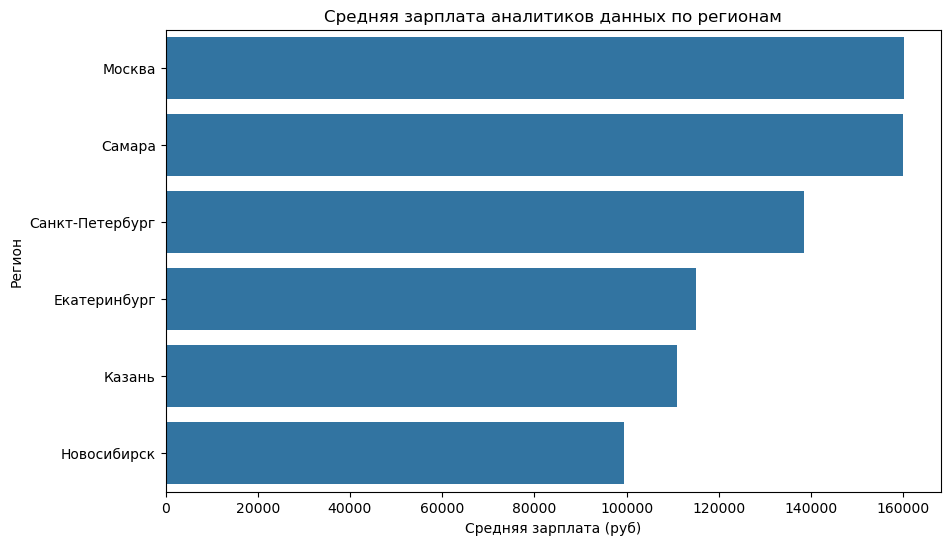

In [7]:
df_salary = df.dropna(subset=["Зарплата от", "Зарплата до"])
df_salary["Средняя зарплата"] = df_salary[["Зарплата от", "Зарплата до"]].mean(axis=1)

# Средняя зарплата по регионам
region_salary = df_salary.groupby("Регион")["Средняя зарплата"].mean().sort_values(ascending=False)

# График
plt.figure(figsize=(10, 6))
sns.barplot(x=region_salary.values, y=region_salary.index)
plt.xlabel("Средняя зарплата (руб)")
plt.ylabel("Регион")
plt.title("Средняя зарплата аналитиков данных по регионам")
plt.show()


In [8]:
df['Регион'].value_counts()

Регион
Москва             182
Санкт-Петербург    155
Екатеринбург        62
Казань              37
Новосибирск         36
Самара               1
Name: count, dtype: int64

In [9]:
# Список городов, которые должны остаться
valid_regions = ["Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург", "Казань"]

# Фильтруем только нужные регионы
df = df[df["Регион"].isin(valid_regions)]

In [10]:
df['Регион'].value_counts()

Регион
Москва             182
Санкт-Петербург    155
Екатеринбург        62
Казань              37
Новосибирск         36
Name: count, dtype: int64

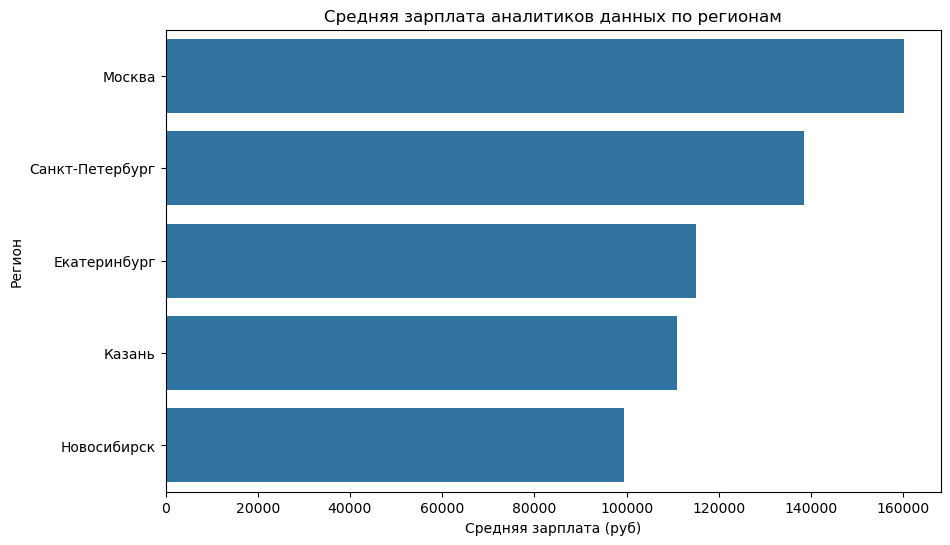

In [11]:
df_salary = df.dropna(subset=["Зарплата от", "Зарплата до"])
df_salary["Средняя зарплата"] = df_salary[["Зарплата от", "Зарплата до"]].mean(axis=1)

# Средняя зарплата по регионам
region_salary = df_salary.groupby("Регион")["Средняя зарплата"].mean().sort_values(ascending=False)

# График
plt.figure(figsize=(10, 6))
sns.barplot(x=region_salary.values, y=region_salary.index)
plt.xlabel("Средняя зарплата (руб)")
plt.ylabel("Регион")
plt.title("Средняя зарплата аналитиков данных по регионам")
plt.show()


### 3. Опыт работы: что чаще требуют?

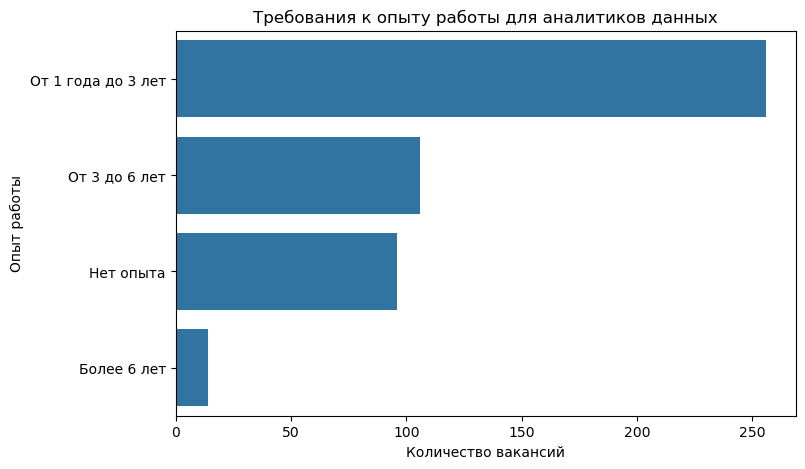

In [13]:
experience_counts = df["Опыт работы"].value_counts()

# График
plt.figure(figsize=(8, 5))
sns.barplot(x=experience_counts.values, y=experience_counts.index)
plt.xlabel("Количество вакансий")
plt.ylabel("Опыт работы")
plt.title("Требования к опыту работы для аналитиков данных")
plt.show()


### 4. Подсчет частоты должностей

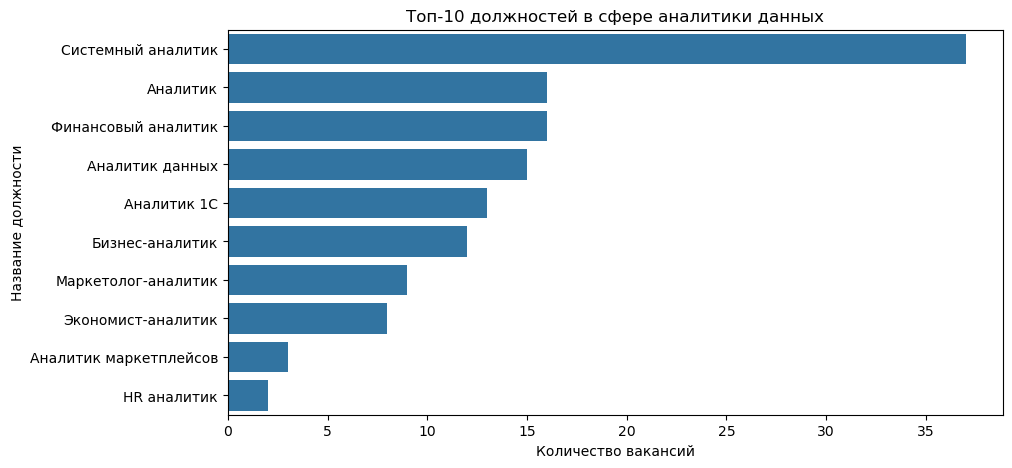

In [14]:
top_jobs = df["Название"].value_counts().head(10)

# График
plt.figure(figsize=(10, 5))
sns.barplot(x=top_jobs.values, y=top_jobs.index)
plt.xlabel("Количество вакансий")
plt.ylabel("Название должности")
plt.title("Топ-10 должностей в сфере аналитики данных")
plt.show()


### 5. Группируем по опыту работы и считаем среднюю зарплату

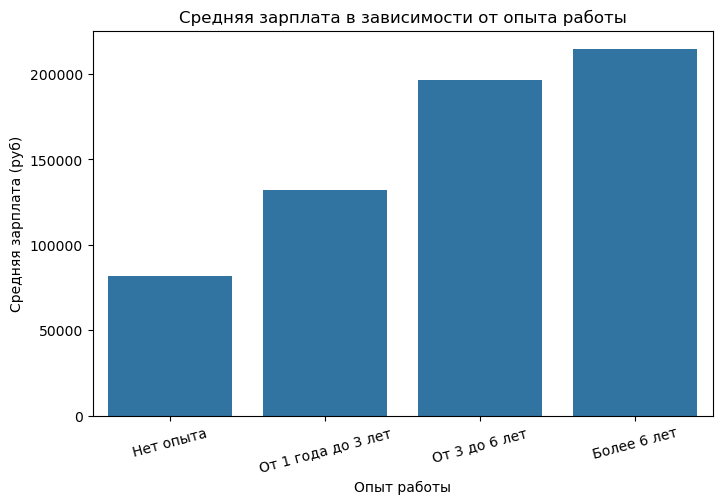

In [15]:
experience_salary = df_salary.groupby("Опыт работы")["Средняя зарплата"].mean().sort_values()

# График
plt.figure(figsize=(8, 5))
sns.barplot(x=experience_salary.index, y=experience_salary.values)
plt.xlabel("Опыт работы")
plt.ylabel("Средняя зарплата (руб)")
plt.title("Средняя зарплата в зависимости от опыта работы")
plt.xticks(rotation=15)
plt.show()


### 6. Гистограмма зарплат

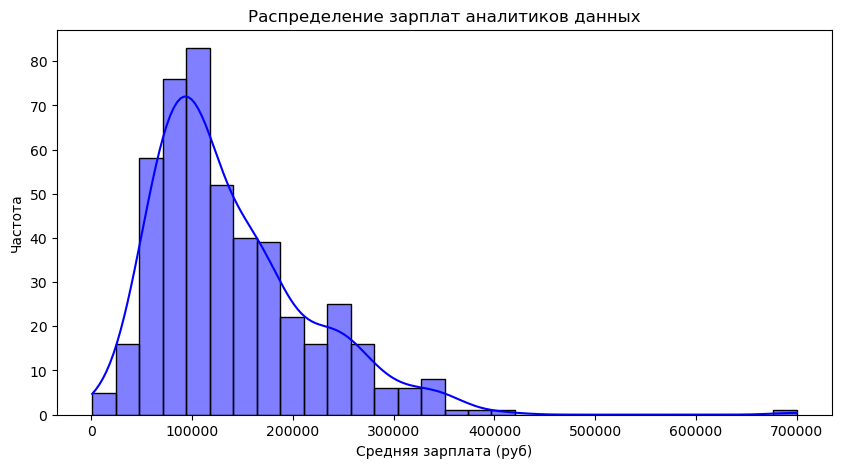

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df_salary["Средняя зарплата"], bins=30, kde=True, color="blue")
plt.xlabel("Средняя зарплата (руб)")
plt.ylabel("Частота")
plt.title("Распределение зарплат аналитиков данных")
plt.show()


### 7. Анализ ключевых навыков в высокооплачиваемых вакансиях

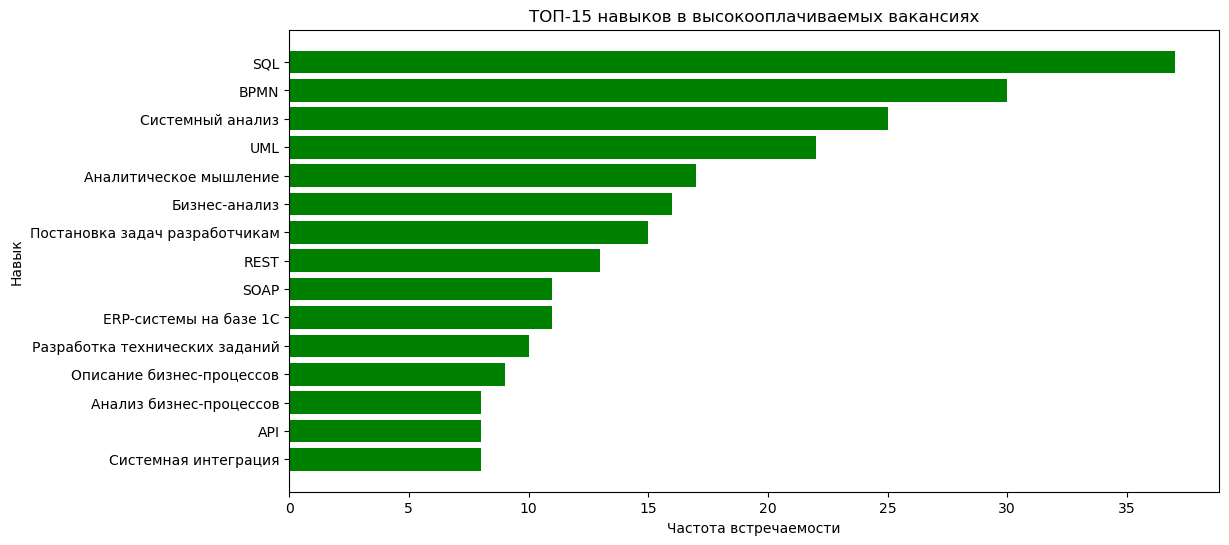

In [20]:
high_salary_threshold = df_salary["Средняя зарплата"].quantile(0.7)
high_salary_vacancies = df_salary[df_salary["Средняя зарплата"] >= high_salary_threshold]

high_salary_skills = high_salary_vacancies[high_salary_vacancies["Ключевые навыки"] != 'Не указаны']["Ключевые навыки"].dropna().str.split(", ")
high_salary_skills = [skill for sublist in high_salary_skills for skill in sublist]  

skills_counter_high_salary = Counter(high_salary_skills)
top_skills_high_salary = skills_counter_high_salary.most_common(15)

# График
plt.figure(figsize=(12, 6))
plt.barh([x[0] for x in top_skills_high_salary], [x[1] for x in top_skills_high_salary], color="green")
plt.xlabel("Частота встречаемости")
plt.ylabel("Навык")
plt.title("ТОП-15 навыков в высокооплачиваемых вакансиях")
plt.gca().invert_yaxis()
plt.show()

### 8. Компании, ищущие аналитиков данных

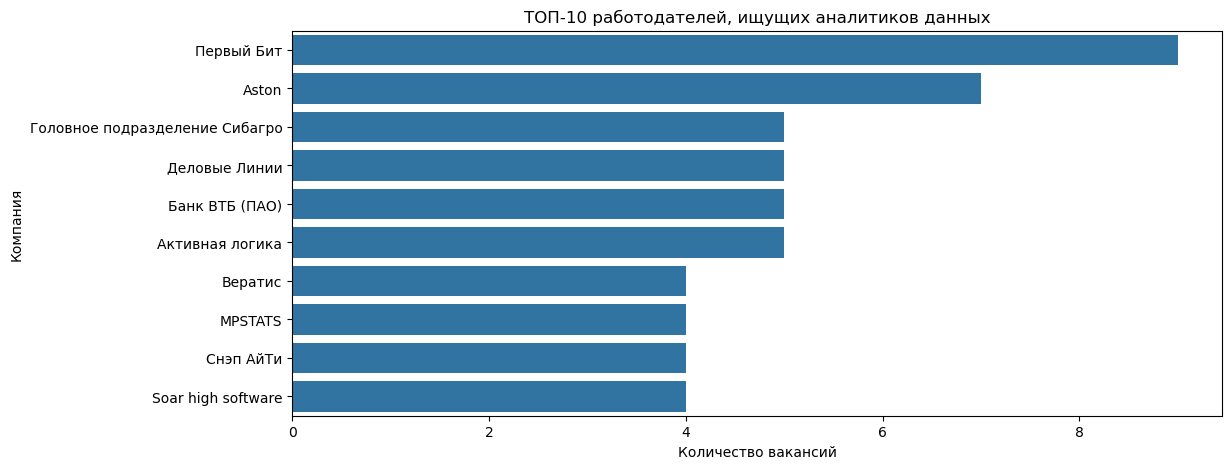

In [21]:
top_employers = df["Компания"].value_counts().head(10)

# График
plt.figure(figsize=(12, 5))
sns.barplot(x=top_employers.values, y=top_employers.index)
plt.xlabel("Количество вакансий")
plt.ylabel("Компания")
plt.title("ТОП-10 работодателей, ищущих аналитиков данных")
plt.show()


In [17]:
print('Компания Первый Бит', df[df["Компания"].str.contains("Первый Бит", case=False, na=False)][["Название"]], sep='\n')
print('Компания ASTON', df[df["Компания"].str.contains("Aston", case=False, na=False)][["Название"]], sep='\n')
print('Компания Сибагро',df[df["Компания"].str.contains("Сибагро", case=False, na=False)][["Название"]], sep='\n')

Компания Первый Бит
                                      Название
213                         Аналитик BI данных
332                 Бизнес-аналитик (удалённо)
522                     Начинающий аналитик 1С
558                                Аналитик 1С
632                      Аналитик 1С (ERP, УТ)
711             Стажер программист/аналитик 1С
743  Младший аналитик 1С (УХ, ERP, БИТ.Финанс)
861                   Аналитик 1С (Оперконтур)
957                     Начинающий аналитик 1С
Компания ASTON
                         Название
209        Дата аналитик (ученик)
575        Дата аналитик (ученик)
583          Аналитик 1С (ученик)
762          Аналитик 1С (стажер)
763   Системный аналитик (ученик)
1113         Аналитик 1С (ученик)
1123  Системный аналитик (ученик)
Компания Сибагро
                                               Название
866                             Аналитик-консультант 1С
879                       Старший системный аналитик 1С
892   Старший системный аналитик (под 